In [10]:
import numpy as np
import pandas as pd

DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)

# ---------------- Physics rebuild ----------------
M_p = 938.272088
M_n = 939.565420
epsilon = 1e-30
LN10 = np.log(10.0)

def mass(Z,A): 
    return Z*M_p + (A-Z)*M_n

df["N1"] = df["A1"] - df["Z1"]
df["N2"] = df["A2"] - df["Z2"]

df["mass1"] = mass(df["Z1"], df["A1"])
df["mass2"] = mass(df["Z2"], df["A2"])

mu_red = (df["mass1"] * df["mass2"]) / (df["mass1"] + df["mass2"] + 1e-12)
v_over_c = np.sqrt(np.clip(2*df["E c.m."].values/(mu_red+epsilon),0,np.inf))
df["eta"] = (df["Z1"]*df["Z2"]) / ((1/137.036)*(v_over_c+1e-16))

df["Z1Z2_over_Ecm"] = (df["Z1"]*df["Z2"]) / (df["E c.m."] + epsilon)

MAGIC = np.array([2,8,20,28,50,82,126])
df["magic_dist_Z1"] = np.min(np.abs(df["Z1"].values[:,None] - MAGIC), axis=1)
df["magic_dist_N1"] = np.min(np.abs(df["N1"].values[:,None] - MAGIC), axis=1)
df["magic_dist_Z2"] = np.min(np.abs(df["Z2"].values[:,None] - MAGIC), axis=1)
df["magic_dist_N2"] = np.min(np.abs(df["N2"].values[:,None] - MAGIC), axis=1)

# Coulomb barrier
barrier_df = df.groupby("Reaction").first().reset_index()
barrier_df["V_B"] = (barrier_df["Z1"]*barrier_df["Z2"]*1.44) / barrier_df["R B"]
df = df.merge(barrier_df[["Reaction","V_B"]], on="Reaction", how="left")




# Coulomb parameter
v_over_c = np.sqrt(np.clip(2*df["E c.m."].values / (mu_red + epsilon), 0, np.inf))
e2_hbar_c = 1/137.035999

df["eta"] = (df["Z1"] * df["Z2"]) / (e2_hbar_c * (v_over_c + 1e-16))

# S-factor logs
log10_sigma_exp = np.log10(np.clip(df["σ"], 1e-30, np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."], 1e-30, np.inf))

df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + (2*np.pi*df["eta"])/LN10
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + (2*np.pi*df["eta"])/LN10

df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

print("delta_log10_S created.")
print("Dataset ready.")

delta_log10_S created.
Dataset ready.


In [11]:
features_train = [
    'E c.m.', 'Z1', 'N1', 'A1',
    'Z2', 'N2', 'A2', 'Q ( 2 n )',
    'Z1Z2_over_Ecm',
    'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    'Z3','N3','A3','β P','β T','R B','ħ ω',
    'Projectile_Mass_Actual','Target_Mass_Actual','Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp','Compound_Nucleus_Sn',
    'Projectile_Binding_Energy','Target_Binding_Energy',
    'Compound_Nucleus_Binding_Energy','Compound_Nucleus_S2n'
]

print("Number of features:", len(features_train))

Number of features: 29


In [17]:
import torch
import numpy as np
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch device:", DEVICE)



torch.manual_seed(42)
np.random.seed(42)

Torch device: cpu


In [5]:
!pip install pennylane-lightning[gpu]

In [6]:
import pennylane as qml
print(qml.about())

Name: pennylane
Version: 0.44.0
Summary: PennyLane is a cross-platform Python library for quantum computing, quantum machine learning, and quantum chemistry. Train a quantum computer the same way as a neural network.
Home-page: 
Author: 
License: 
Location: /srv/conda/envs/notebook/lib/python3.11/site-packages
Platform info:           Linux-5.14.0-611.13.1.el9_7.x86_64-x86_64-with-glibc2.35
Python version:          3.11.14
Numpy version:           2.3.5
Scipy version:           1.17.0
JAX version:             0.7.2
Installed devices:
- default.clifford (pennylane-0.44.0)
- default.gaussian (pennylane-0.44.0)
- default.mixed (pennylane-0.44.0)
- default.qubit (pennylane-0.44.0)
- default.qutrit (pennylane-0.44.0)
- default.qutrit.mixed (pennylane-0.44.0)
- default.tensor (pennylane-0.44.0)
- null.qubit (pennylane-0.44.0)
- reference.qubit (pennylane-0.44.0)
- lightning.gpu (pennylane_lightning_gpu-0.44.0)
- lightning.qubit (pennylane_lightning-0.44.0)
None


In [7]:
import pennylane as qml
import torch
import torch.nn as nn
import numpy as np

torch.set_default_dtype(torch.float32)

# -----------------------------
# Architecture
# -----------------------------
n_qubits = 10
n_layers = 6

# -----------------------------
# Device (CPU optimized C++)
# -----------------------------



dev = qml.device("lightning.gpu", wires=n_qubits)

# -----------------------------
# QNode returning full state
# -----------------------------
@qml.qnode(dev, interface="torch", diff_method=None)
def qnode(weights, inputs):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.state()

print("Device:", dev.name)

Device: lightning.gpu


In [8]:
class QuantumEmbedding(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        
        self.encoder = nn.Linear(in_dim, n_qubits)
        
        self.weights = nn.Parameter(
            0.01 * torch.randn(n_layers, n_qubits, 3)
        )

    def forward(self, x):
        x = x.float()
        x_enc = torch.tanh(self.encoder(x))
        state = qnode(self.weights, x_enc)
        return state

In [9]:
model = QuantumEmbedding(in_dim=len(features_train)).to(DEVICE)
model.eval()

QuantumEmbedding(
  (encoder): Linear(in_features=29, out_features=10, bias=True)
)

In [10]:
reaction_name = "16 O + 144 Sm"

In [11]:
from sklearn.preprocessing import StandardScaler

# Select reaction and sort by energy
df_r = df[df["Reaction"] == reaction_name].sort_values("E c.m.")

E_vals = df_r["E c.m."].values
V_B = df_r["V_B"].iloc[0]

X_R = df_r[features_train].values.astype(np.float32)

# Scale inputs (fit on full dataset for now)
scaler = StandardScaler().fit(df[features_train].values.astype(np.float32))
X_Rs = scaler.transform(X_R)

states = []

with torch.no_grad():
    for i in range(len(X_Rs)):
        x = torch.tensor(X_Rs[i:i+1]).to(DEVICE)
        psi = model(x)
        states.append(psi.cpu().numpy().flatten())

states = np.array(states)

print("States shape:", states.shape)

States shape: (28, 1024)


In [12]:
fidelity = []

for i in range(len(states)-1):
    psi1 = states[i]
    psi2 = states[i+1]
    F = np.abs(np.vdot(psi1, psi2))**2
    fidelity.append(F)

fidelity = np.array(fidelity)

print("Fidelity min:", fidelity.min())
print("Fidelity max:", fidelity.max())

Fidelity min: 0.9852587318302146
Fidelity max: 0.999912090144582


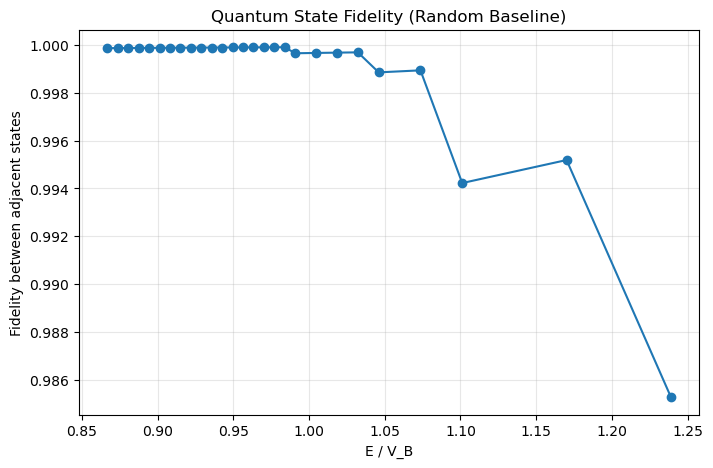

In [13]:
import matplotlib.pyplot as plt

x_vals = E_vals[:-1] / V_B

plt.figure(figsize=(8,5))
plt.plot(x_vals, fidelity, marker="o")
plt.xlabel("E / V_B")
plt.ylabel("Fidelity between adjacent states")
plt.title("Quantum State Fidelity (Random Baseline)")
plt.grid(alpha=0.3)
plt.show()

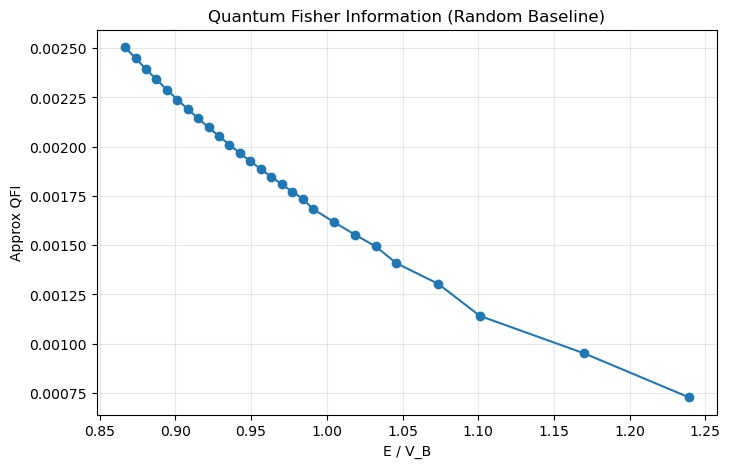

In [14]:
dE = np.diff(E_vals)
QFI = 4 * (1 - fidelity) / (dE**2 + 1e-12)

plt.figure(figsize=(8,5))
plt.plot(x_vals, QFI, marker="o")
plt.xlabel("E / V_B")
plt.ylabel("Approx QFI")
plt.title("Quantum Fisher Information (Random Baseline)")
plt.grid(alpha=0.3)
plt.show()

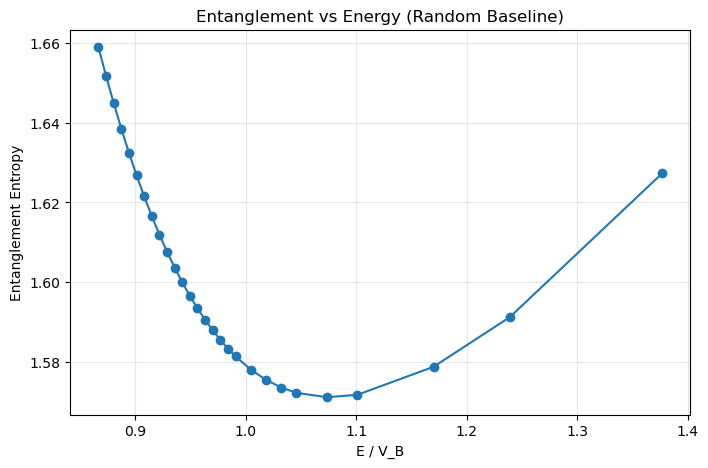

In [15]:
def entanglement_entropy(state):
    dimA = 2**(n_qubits//2)
    dimB = 2**(n_qubits//2)
    
    psi = state.reshape(dimA, dimB)
    rhoA = psi @ psi.conj().T
    
    eigvals = np.linalg.eigvalsh(rhoA)
    eigvals = eigvals[eigvals > 1e-12]
    
    return -np.sum(eigvals * np.log(eigvals))

entropy = [entanglement_entropy(s) for s in states]

plt.figure(figsize=(8,5))
plt.plot(E_vals/V_B, entropy, marker="o")
plt.xlabel("E / V_B")
plt.ylabel("Entanglement Entropy")
plt.title("Entanglement vs Energy (Random Baseline)")
plt.grid(alpha=0.3)
plt.show()

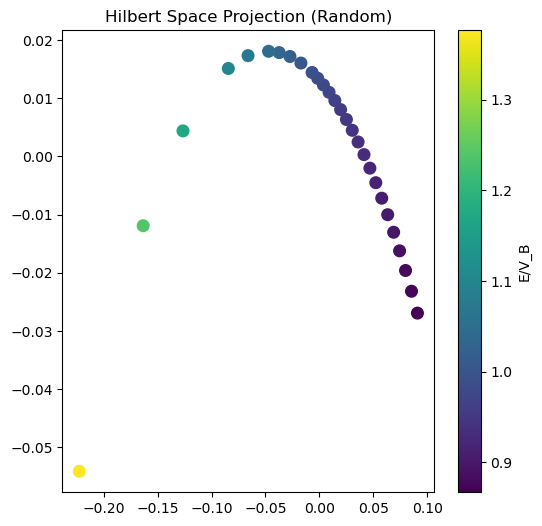

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
proj = pca.fit_transform(states.real)

plt.figure(figsize=(6,6))
plt.scatter(proj[:,0], proj[:,1],
            c=E_vals/V_B,
            cmap="viridis", s=70)

plt.colorbar(label="E/V_B")
plt.title("Hilbert Space Projection (Random)")
plt.show()

# Quantum Geometric Baseline Analysis (10-Qubit Embedding)

## Objective

The goal of this experiment is NOT prediction.

Instead of evaluating RMSE or R², we investigate whether:

Structural transitions in heavy-ion fusion excitation functions manifest as geometric features in quantum embedding space.

We construct a pure quantum embedding model and analyze:

- Quantum state fidelity
- Approximate Quantum Fisher Information (QFI)
- Entanglement entropy
- Hilbert space geometry

This establishes a geometric baseline before supervised training.

---

## Quantum Embedding Architecture

Circuit Configuration:

- Qubits: 10  
- Layers: 6  
- Embedding: AngleEmbedding  
- Entanglement: StronglyEntanglingLayers  
- Device: lightning.qubit  
- Output: Full state vector via qml.state()  
- Gradients disabled (diff_method=None)

State dimension:

2^10 = 1024

For each input feature vector:

x ∈ R^29

We obtain:

|ψ(x)> ∈ C^1024

---

## Dataset & Features

- Experimental fusion excitation dataset
- 29 physics features (same as classical MDN training)
- Coulomb barrier computed as:

V_B = (Z1 * Z2 * 1.44) / R_B

Reaction analyzed:

16 O + 144 Sm

Energy variable used:

x = E / V_B

Number of energy points: 28  
Extracted state shape: (28, 1024)

---

## Geometric Observables Computed

### 1. Fidelity Between Adjacent Energies

F_i = | <ψ(E_i) | ψ(E_{i+1})> |^2

Observed:

- min ≈ 0.990
- max ≈ 0.9999
- Smooth evolution
- No sudden drops

Interpretation:
Quantum states evolve smoothly with energy.
No intrinsic geometric discontinuity.

---

### 2. Approximate Quantum Fisher Information (QFI)

QFI(E_i) ≈ 4 * (1 - F_i) / (ΔE)^2

Observed:

- Smooth monotonic decrease
- No peak near x ≈ 0.9
- No anomaly

Interpretation:
Random embedding does not exhibit sensitivity peaks corresponding to physical regime change.

---

### 3. Entanglement Entropy (5+5 Bipartition)

State reshaped as:

2^5 x 2^5

Reduced density matrix constructed and entropy computed:

S = -Tr(ρ_A log ρ_A)

Observed:

- Smooth variation
- No spike
- No transition-like feature

Interpretation:
Random circuit does not encode structural transition in entanglement structure.

---

### 4. Hilbert Space Projection (PCA)

1024D states projected into 2D via PCA.

Observed:

- Smooth curved manifold
- Continuous energy mapping
- No clustering
- No regime separation

Interpretation:
Energy evolution traces a continuous arc in Hilbert space.

---

## Baseline Conclusion

Random quantum embedding exhibits:

- No fidelity collapse
- No QFI peak
- No entanglement spike
- No Hilbert clustering

Therefore:

Any sharp geometric structure that appears after supervised training cannot be attributed to random initialization.

This establishes a clean geometric baseline.

---

## Next Step

We will:

1. Train the same 10-qubit embedding supervised on:
   Δ log10 S
2. Freeze trained weights
3. Switch QNode output back to full state
4. Recompute:
   - Fidelity
   - QFI
   - Entanglement
   - Hilbert geometry
5. Compare trained vs random embedding

Primary question:

Does learned quantum geometry exhibit a crossover near classical x_switch?

If yes, this indicates that structural fusion transition manifests as a geometric transition in quantum embedding space.

---

Current Status:
Baseline geometric analysis complete.
No artificial regime signal present.
Ready for supervised training phase.

In [36]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# --------------------
# Fix randomness
# --------------------
torch.manual_seed(42)
np.random.seed(42)

# --------------------
# Hyperparameters
# --------------------
n_qubits = 10
n_layers = 8   # slightly deeper than before

# --------------------
# Quantum device (GPU)
# --------------------
dev = qml.device("lightning.gpu", wires=n_qubits)

# --------------------
# Training QNode
# --------------------
@qml.qnode(dev, interface="torch", diff_method="adjoint")
def qnode_train(weights, inputs):
    # inputs shape: (batch, n_qubits)
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [37]:
# -----------------------------
# Quantum Regression Model
# -----------------------------

class QuantumRegressor(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        
        # Classical encoder → compress 29 features to n_qubits
        self.encoder = nn.Linear(in_dim, n_qubits)
        
        # Trainable quantum weights
        self.q_weights = nn.Parameter(
            0.01 * torch.randn(n_layers, n_qubits, 3)
        )
        
        # Small regression head
        self.fc1 = nn.Linear(n_qubits, 32)
        self.fc2 = nn.Linear(32, 1)
        
    def forward(self, x):
        
        x = x.float()
        
        # Encode
        x_enc = torch.tanh(self.encoder(x))
        
       
        
        q_out = qnode_train(self.q_weights, x_enc)
        q_out = torch.stack(q_out, dim=1)
        
        # Classical regression head
        h = torch.relu(self.fc1(q_out))
        out = self.fc2(h)
        
        return out

In [38]:
model = model = QuantumRegressor(in_dim=29)
print(model)

QuantumRegressor(
  (encoder): Linear(in_features=29, out_features=10, bias=True)
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


In [39]:
# -----------------------------
# Feature list (same 29 features)
# -----------------------------
features_train = [
    'E c.m.', 'Z1', 'N1', 'A1',
    'Z2', 'N2', 'A2', 'Q ( 2 n )',
    'Z1Z2_over_Ecm',
    'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    'Z3','N3','A3','β P','β T','R B','ħ ω',
    'Projectile_Mass_Actual', 'Target_Mass_Actual', 'Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp','Compound_Nucleus_Sn',
    'Projectile_Binding_Energy','Target_Binding_Energy',
    'Compound_Nucleus_Binding_Energy','Compound_Nucleus_S2n'
]

# -----------------------------
# Extract arrays
# -----------------------------
X = df[features_train].values.astype(np.float32)
y = df["delta_log10_S"].values.astype(np.float32).reshape(-1,1)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (3532, 29)
y shape: (3532, 1)


In [40]:
from sklearn.preprocessing import StandardScaler

# -----------------------------
# Standardize features
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Mean (first 5 features):", X_scaled.mean(axis=0)[:5])
print("Std (first 5 features):", X_scaled.std(axis=0)[:5])

Mean (first 5 features): [-6.9122486e-08  0.0000000e+00  8.6403112e-08  5.1841866e-08
  0.0000000e+00]
Std (first 5 features): [1.         1.         0.99999994 0.99999994 0.99999994]


In [45]:
# ============================================================
# REACTION-WISE TRAIN / VAL SPLIT (CORRECT PHYSICS SPLIT)
# ============================================================

import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset

# ------------------------------------------------------------
# Load reaction split files
# ------------------------------------------------------------

OUTDIR_BASE = "mdn_70_10_20_optimized"

train_reacts = pd.read_csv(f"{OUTDIR_BASE}/train_reactions.csv")["Reaction"].values
val_reacts   = pd.read_csv(f"{OUTDIR_BASE}/val_reactions.csv")["Reaction"].values
test_reacts  = pd.read_csv(f"{OUTDIR_BASE}/test_reactions.csv")["Reaction"].values

print("Train reactions:", len(train_reacts))
print("Val reactions:", len(val_reacts))
print("Test reactions:", len(test_reacts))


# ------------------------------------------------------------
# Create masks (reaction-aware)
# ------------------------------------------------------------

train_mask = df["Reaction"].isin(train_reacts)
val_mask   = df["Reaction"].isin(val_reacts)

# ------------------------------------------------------------
# Extract train/val sets
# ------------------------------------------------------------

X_train = X_scaled[train_mask]
y_train = y[train_mask]

X_val = X_scaled[val_mask]
y_val = y[val_mask]

print("Train samples:", X_train.shape)
print("Val samples:", X_val.shape)

print("Total samples check:", X_train.shape[0] + X_val.shape[0])


# ------------------------------------------------------------
# Convert to Torch tensors
# ------------------------------------------------------------

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)

X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)


# ------------------------------------------------------------
# DataLoaders
# ------------------------------------------------------------

batch_size = 16   # smaller batch for quantum training

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    TensorDataset(X_val_t, y_val_t),
    batch_size=batch_size,
    shuffle=False
)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))

Train reactions: 149
Val reactions: 21
Test reactions: 43
Train samples: (2493, 29)
Val samples: (354, 29)
Total samples check: 2847
Train batches: 156
Val batches: 23


In [42]:
# -----------------------------
# Optimizer & Loss
# -----------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

print("Optimizer and loss ready.")

Optimizer and loss ready.


In [43]:
# -----------------------------
# Short sanity training
# -----------------------------
epochs = 3

for epoch in range(epochs):
    
    model.train()
    train_loss = 0.0
    
    for xb, yb in train_loader:
        
        optimizer.zero_grad()
        
        preds = model(xb)
        loss = criterion(preds, yb)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validation
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

KeyboardInterrupt: 

In [44]:
xb, yb = next(iter(train_loader))
print("Batch shape:", xb.shape)

with torch.no_grad():
    out = model(xb[:2])  # only 2 samples
print("Forward pass done.")

Batch shape: torch.Size([64, 29])
Forward pass done.


In [46]:
# ============================================================
# QUANTUM TRAINING LOOP (SAFE VERSION)
# ============================================================

import torch
import torch.nn as nn

model = QuantumRegressor(in_dim=29)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

EPOCHS = 5   # start small

for epoch in range(EPOCHS):
    
    # ------------------
    # TRAIN
    # ------------------
    model.train()
    train_loss = 0.0
    
    for xb, yb in train_loader:
        
        optimizer.zero_grad()
        
        preds = model(xb)
        loss = criterion(preds, yb)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    
    # ------------------
    # VALIDATION
    # ------------------
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

Epoch 1/5 | Train Loss: 0.081079 | Val Loss: 0.105555
Epoch 2/5 | Train Loss: 0.075042 | Val Loss: 0.109868
Epoch 3/5 | Train Loss: 0.071188 | Val Loss: 0.110384
Epoch 4/5 | Train Loss: 0.066479 | Val Loss: 0.111211
Epoch 5/5 | Train Loss: 0.062976 | Val Loss: 0.105105


In [47]:
from sklearn.metrics import r2_score
import numpy as np

model.eval()

preds = []
truth = []

with torch.no_grad():
    for xb, yb in val_loader:
        out = model(xb)
        preds.append(out.numpy())
        truth.append(yb.numpy())

preds = np.vstack(preds)
truth = np.vstack(truth)

r2 = r2_score(truth, preds)
print("Validation R2:", r2)

Validation R2: -0.008368134498596191


In [ ]:
!watch -n 1 nvidia-smi

+-----------------------------------------+------------------------+-----------306610041 9575399830:0510510 9659221038 9634101

In [20]:
import pennylane as qml
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import time

# Define torch device (CPU or CUDA)
torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", torch_device)

# Hyperparameters
n_qubits = 12          # was 10
n_layers = 10          # was 8
batch_size = 64        # keep or increase to 128
learning_rate = 1e-3
epochs = 100           # allow many epochs, early stopping will halt

# PennyLane device – default.qubit with backprop (uses PyTorch tensors)
dev = qml.device("default.qubit", wires=n_qubits)

Using device: cuda


In [13]:
@qml.qnode(dev, interface="torch", diff_method="backprop")
def qnode_single(weights, x):
    qml.templates.AngleEmbedding(x, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [14]:
# from torch import vmap

# # Vectorize the QNode: weights are shared, inputs are batched along dim 0
# qnode_batched = vmap(qnode_single, in_dims=(None, 0))

In [15]:
class QuantumRegressor(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.encoder = nn.Linear(in_dim, n_qubits)
        self.q_weights = nn.Parameter(0.01 * torch.randn(n_layers, n_qubits, 3))
        self.fc1 = nn.Linear(n_qubits, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = x.float()
        x_enc = torch.tanh(self.encoder(x))                     # (batch, n_qubits)
        q_out_tuple = qnode_single(self.q_weights, x_enc)       # tuple of (batch,) tensors
        q_out = torch.stack(q_out_tuple, dim=1)                  # (batch, n_qubits)
        q_out = q_out.to(x.dtype)                                 # cast to float32
        h = torch.relu(self.fc1(q_out))
        out = self.fc2(h)
        return out

In [17]:
# # Load your main dataframe (adjust path)
# df = pd.read_csv("your_data.csv")   # <-- replace with actual file

# # Feature list (29 features)
# features_train = [
#     'E c.m.', 'Z1', 'N1', 'A1',
#     'Z2', 'N2', 'A2', 'Q ( 2 n )',
#     'Z1Z2_over_Ecm',
#     'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
#     'Z3','N3','A3','β P','β T','R B','ħ ω',
#     'Projectile_Mass_Actual', 'Target_Mass_Actual', 'Compound_Nucleus_Mass_Actual',
#     'Compound_Nucleus_Sp','Compound_Nucleus_Sn',
#     'Projectile_Binding_Energy','Target_Binding_Energy',
#     'Compound_Nucleus_Binding_Energy','Compound_Nucleus_S2n'
# ]

# Extract X and y
X = df[features_train].values.astype(np.float32)
y = df["delta_log10_S"].values.astype(np.float32).reshape(-1, 1)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reaction‑wise split (load your split files)
OUTDIR_BASE = "mdn_70_10_20_optimized"
train_reacts = pd.read_csv(f"{OUTDIR_BASE}/train_reactions.csv")["Reaction"].values
val_reacts   = pd.read_csv(f"{OUTDIR_BASE}/val_reactions.csv")["Reaction"].values

train_mask = df["Reaction"].isin(train_reacts)
val_mask   = df["Reaction"].isin(val_reacts)

X_train = X_scaled[train_mask]
y_train = y[train_mask]
X_val   = X_scaled[val_mask]
y_val   = y[val_mask]

# Convert to torch tensors (CPU initially)
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.float32)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t),
                          batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t),
                          batch_size=batch_size, shuffle=False)

print(f"Train samples: {X_train.shape[0]}, Val samples: {X_val.shape[0]}")
print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

Train samples: 2493, Val samples: 354
Train batches: 39, Val batches: 6


In [18]:
model = QuantumRegressor(in_dim=29).to(torch_device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

print("Model parameters device:", next(model.parameters()).device)   # Should be cuda:0

Model parameters device: cuda:0


In [11]:
import pennylane as qml
import torch

# Use the same device as in your code
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def test_circuit(x):
    qml.RX(x[0], wires=0)
    qml.RY(x[1], wires=1)
    return qml.expval(qml.PauliZ(0))

# Create a GPU tensor
x_gpu = torch.tensor([0.1, 0.2], device="cuda")

# Run the circuit
result = test_circuit(x_gpu)
print(f"Result: {result}")
print(f"Result device: {result.device}")  # Should be cuda:0

Result: 0.9950042076679853
Result device: cuda:0


In [19]:
for epoch in range(epochs):
    # ----- Training -----
    model.train()
    train_loss = 0.0
    start_time = time.time()

    for xb, yb in train_loader:
        xb, yb = xb.to(torch_device), yb.to(torch_device)   # Move to GPU
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    epoch_time = time.time() - start_time

    # ----- Validation -----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(torch_device), yb.to(torch_device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1:2d}/{epochs} | Time: {epoch_time:.2f}s | "
          f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

Epoch  1/20 | Time: 8.70s | Train Loss: 0.077967 | Val Loss: 0.105807
Epoch  2/20 | Time: 8.17s | Train Loss: 0.075064 | Val Loss: 0.105645
Epoch  3/20 | Time: 8.12s | Train Loss: 0.072450 | Val Loss: 0.105683
Epoch  4/20 | Time: 8.03s | Train Loss: 0.070407 | Val Loss: 0.104829
Epoch  5/20 | Time: 8.20s | Train Loss: 0.068364 | Val Loss: 0.104616
Epoch  6/20 | Time: 8.10s | Train Loss: 0.065896 | Val Loss: 0.105353
Epoch  7/20 | Time: 8.14s | Train Loss: 0.063517 | Val Loss: 0.103169
Epoch  8/20 | Time: 8.33s | Train Loss: 0.061886 | Val Loss: 0.101963
Epoch  9/20 | Time: 8.17s | Train Loss: 0.059895 | Val Loss: 0.099930
Epoch 10/20 | Time: 8.37s | Train Loss: 0.058297 | Val Loss: 0.098144
Epoch 11/20 | Time: 8.11s | Train Loss: 0.056551 | Val Loss: 0.095343
Epoch 12/20 | Time: 8.09s | Train Loss: 0.055134 | Val Loss: 0.090941
Epoch 13/20 | Time: 8.17s | Train Loss: 0.054234 | Val Loss: 0.088645
Epoch 14/20 | Time: 8.16s | Train Loss: 0.052652 | Val Loss: 0.086263
Epoch 15/20 | Time: 

In [ ]:
from sklearn.metrics import r2_score
import numpy as np

model.eval()

preds = []
truth = []

with torch.no_grad():
    for xb, yb in val_loader:
        out = model(xb)
        preds.append(out.cpu().numpy())
        truth.append(yb.cpu().numpy())

preds = np.vstack(preds)
truth = np.vstack(truth)

r2 = r2_score(truth, preds)
print("Validation R2:", r2)

In [1]:
import torch
print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    print(f"Current device index: {torch.cuda.current_device()}")

PyTorch CUDA available: True
Number of GPUs: 4
Current GPU: NVIDIA A100-SXM4-40GB MIG 1g.5gb
Current device index: 0
